In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv('ITC.csv')
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ITC,EQ,656.00,694.00,708.50,675.0,708.50,708.50,701.81,562715,3.949174e+13,NaN,NaN,NaN
1,2000-01-04,ITC,EQ,708.50,714.00,729.00,694.3,710.65,712.35,714.16,712637,5.089379e+13,NaN,NaN,NaN
2,2000-01-05,ITC,EQ,712.35,716.25,758.90,660.0,731.00,726.20,732.43,1382149,1.012325e+14,NaN,NaN,NaN
3,2000-01-06,ITC,EQ,726.20,741.00,784.30,741.0,784.30,784.30,776.63,721618,5.604266e+13,NaN,NaN,NaN
4,2000-01-07,ITC,EQ,784.30,832.40,847.05,824.0,847.05,847.05,841.25,231209,1.945046e+13,NaN,NaN,NaN


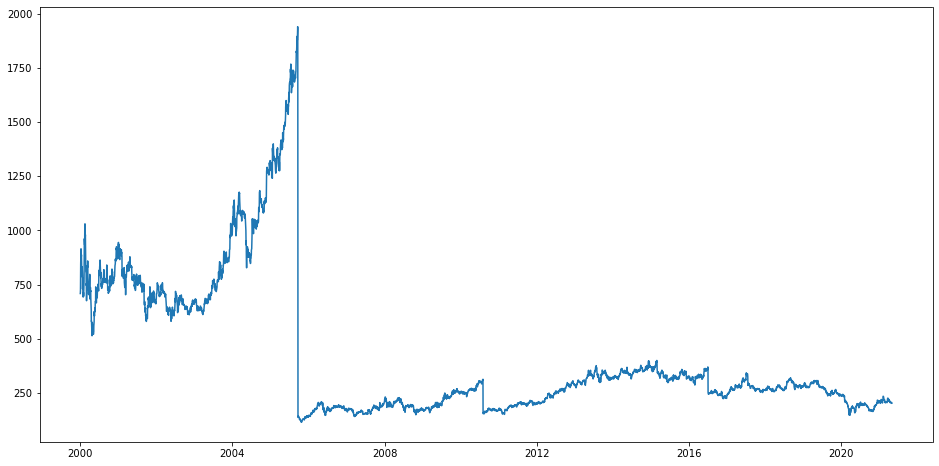

In [3]:
df['Date']=pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'],label='Close Price History')

In [4]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(len(data)):
    new_dataset['Date'][i]=data['Date'][i]
    new_dataset['Close'][i]=data['Close'][i]

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

#taking 70% training and 30%test; samples=5306
train_data=final_dataset[0:3714,:]
valid_data=final_dataset[3714:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop('Date',axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
features=['Close']
scaled_data=scaler.fit_transform(new_dataset[features])

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [6]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

3654/3654 - 48s - loss: 0.0022 - 48s/epoch - 13ms/step


In [7]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [8]:
lstm_model.save("saved_model.h5")

<ipython-input-9-034f955417b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


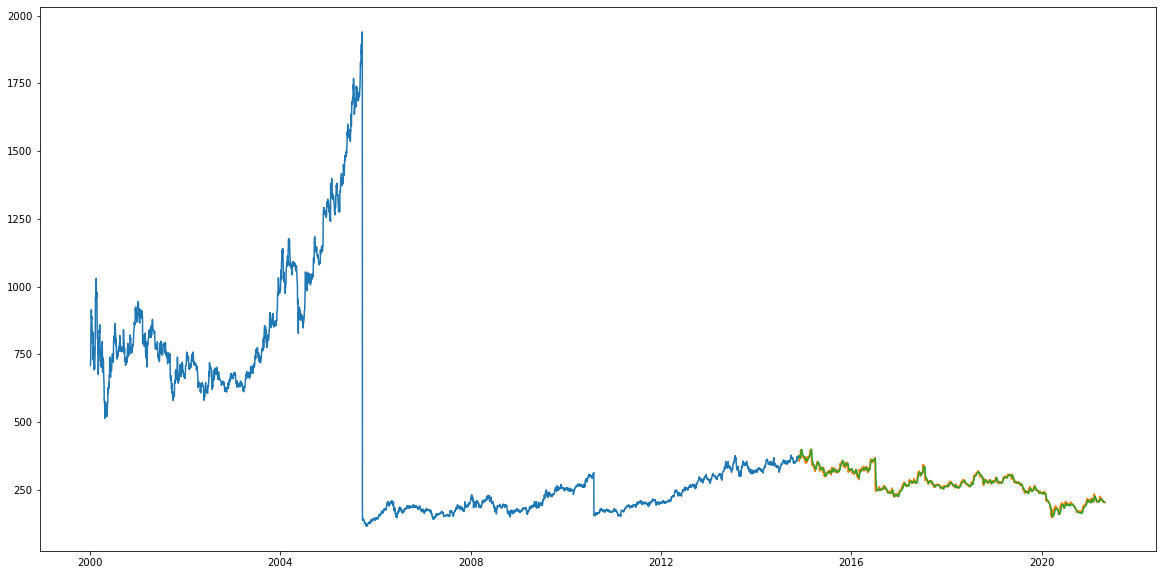

In [9]:
train_data=new_dataset[:3714]
valid_data=new_dataset[3714:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])  'Plotting the Prediction curve along with the actual curve'

In [15]:
#Error Metrics
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_MAPE(y_true, y_pred):
    'Calculate the Mean Absolute Percentage Error(MAPE)'
    mape=np.mean(np.abs((y_true-y_pred)/y_true))*100
    return mape

In [17]:
#calculating the error metrics
rmse=calculate_rmse(valid_data['Close'],valid_data['Predictions'])
mape=calculate_MAPE(valid_data['Close'],valid_data['Predictions'])

In [28]:
#Result

print('The Root Mean Squared Error (RMSE) was found to be ',end="")
print(round(rmse,3))
print('\nThe Mean Absolute Percentage Error (MAPE) was found to be ',end='')
print(round(mape,2),end='%')

The Root Mean Squared Error (RMSE) was found to be 8.519

The Mean Absolute Percentage Error (MAPE) was found to be 2.01%